<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/CartPole%EF%BC%BFPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stable-baselines3
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
import random
import time
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.optim as optim

from collections import deque, namedtuple
from itertools import count
from IPython.display import clear_output

In [13]:
class DQN(nn.Module):
    def __init__(self, obs_length, hidden_side, action_num):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_length, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.do1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.do2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, action_num)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = self.ln1(h)
        h = self.do1(h)
        h = F.relu(self.fc2(h))
        h = self.ln2(h)
        h = self.do2(h)
        y = self.fc3(h)
        return y

In [10]:
class ReplayMemory:
    global Transition
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def get_len(self):
        return len(self.memory)

In [18]:
class TrainMain:
    def __init__(self, hidden_size, action_num, batch_size, num_episode, max_steps, memory_size, gamma, TAU, display_freq):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('device=', self.device)
        self.env = gym.make('CartPole-v0')
        self.env._max_episode_steps = max_steps
        state = self.env.reset()
        self.batch_size = batch_size
        self.num_episode = num_episode
        self.max_steps = max_steps
        self.memory_size = memory_size
        self.gamma = gamma
        self.TAU = TAU
        self.display_freq = display_freq
        self.next_display = display_freq
        self.target_nn = DQN(len(state), hidden_size, action_num).to(self.device)
        self.q_nn = DQN(len(state), hidden_size, action_num).to(self.device)
        self.target_nn.load_state_dict(self.q_nn.state_dict())
        self.optimizer = optim.Adam(self.q_nn.parameters(), lr=1e-03)
        self.memory = ReplayMemory(self.memory_size)
        self.eps = 0.99
        self.eps_min = 0.0
        self.eps_decay = int(num_episode * 0.2)
        self.log_loss = []
        self.log_reward = []
        self.log_duration = []
    
    def select_action(self, state, current_step):
        if (self.eps_min + (self.eps - self.eps_min) * math.exp(-1.0 * current_step / self.eps_decay)) > random.random():
            with torch.no_grad():
                return self.q_nn(state).max(1)[1].view(1,1) ##return unit of maximum output
        else:
            return torch.tensor([[self.env.action_space.sample()]], device = self.device, dtype=torch.int)
    
    def optimize_model(self):
        if self.memory.get_len() < self.batch_size:
            return
        else:
            transitions = self.memory.sample(self.batch_size)
            batch = self.memory.Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = self.device, dtype=torch.bool) #next_stateがNoneになっているか否かでtrue, falseのmask作成
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
            state_action_values = self.q_nn(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(self.batch_size, device = self.device)
            with torch.no_grad():                
                next_state_values[non_final_mask] = self.target_nn(non_final_next_states).max(1)[0]
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
            #compute huber loss
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            self.log_loss.append(loss.clone().detach().cpu().numpy().sum())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.q_nn.parameters(), 100)
            self.optimizer.step()

    def display_chart(self, episode):
        if episode >= self.next_display:            
            fig = plt.figure(figsize = (10,6), facecolor='lightblue')
            ax1 = fig.add_subplot(2,1,1)
            ax2 = fig.add_subplot(2,1,2)
            ax1.plot(np.arange(len(self.log_duration)), self.log_duration, color='blue', label='duration')
            ax2.plot(np.arange(len(self.log_loss)), self.log_loss, color='red', label='loss')
            plt.cla()
            plt.show()
            self.next_display += self.display_freq
    
    def training_loop(self):
        for i in range(self.num_episode):
            state = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for t in count():
                action = self.select_action(state, t)
                next_state, reward, is_done, truncated = self.env.step(action.item())
                self.log_reward.append(reward)
                reward = torch.tensor([reward], device=self.device)
                if is_done:
                    next_state = None
                else:
                    next_state = torch.tensor(next_state, dtype = torch.float32, device=self.device).unsqueeze(0)
                self.memory.push(state, action, next_state, reward)
                state = next_state
                self.optimize_model()
                target_nn_state_dict = self.target_nn.state_dict()
                q_nn_state_dict = self.q_nn.state_dict()
                for key in q_nn_state_dict:
                    target_nn_state_dict[key] = q_nn_state_dict[key] * self.TAU + target_nn_state_dict[key] * (1-self.TAU)
                    self.target_nn.load_state_dict(target_nn_state_dict)
                if is_done:
                    self.log_duration.append(t+1)
                    break
            clear_output(wait=True)
            self.display_chart(i)
        self.display_chart(self.num_episode * 2)
        print('Completed !')

In [19]:
hidden_size = 16
batch_size = 1280
num_episode = 10000
max_steps = 40000
display_freq = 10
memory_size = 10000
gamma = 0.99
TAU = 0.005

st = time.time()
dqn = TrainMain(hidden_size, 2, batch_size, num_episode, max_steps, memory_size, gamma, TAU, display_freq)
dqn.training_loop()
print('time=', time.time() - st)

KeyboardInterrupt: ignored

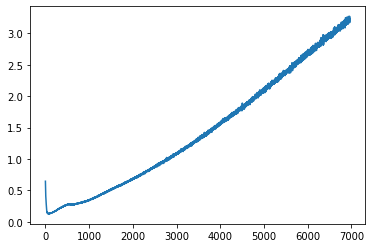

In [17]:
dqn.log_loss

duration= 10
duration= 11


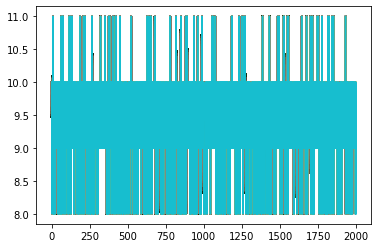

In [8]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim

# create the CartPole environment
env = gym.make('CartPole-v0')
env._max_episode_steps = 4000

# define the neural network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

# initialize the policy network
policy_net = PolicyNetwork(4, 2)

# define the optimizer
optimizer = optim.Adam(policy_net.parameters())

# define the loss function
loss_fn = nn.CrossEntropyLoss()

# set the number of episodes
num_episodes = 2000

# set the maximum duration of the CartPole
max_duration = 4000
durations = []
# train the policy network
current_max = 0
for episode in range(num_episodes):
    # reset the environment
    state = env.reset()
    done = False
    duration = 0
    while not done:
        # convert the state to a tensor
        state = torch.from_numpy(state).float()
        # forward pass through the policy network
        action_probs = policy_net(state)
        # sample an action from the action probabilities
        action = torch.argmax(action_probs).item()
        # take the action in the environment
        next_state, reward, done, _ = env.step(action)
        # update the state
        state = next_state
        # update the duration
        duration += 1
        # check if the duration has exceeded the maximum
        if duration >= max_duration:
            done = True
    # calculate the loss
    loss = loss_fn(action_probs.unsqueeze(0), torch.tensor([action]))
    # backpropagate the loss
    loss.backward()
    # update the policy network's parameters
    optimizer.step()
    # reset the optimizer's gradients
    optimizer.zero_grad()
    durations.append(duration)
    if current_max < duration:
        current_max = duration
        print('duration=', current_max)
    plt.plot(durations)